In [22]:
from scnn.bipolar_functions.layers import *
from scnn.bipolar_functions.operations import *
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import torch

In [2]:
from scnn.convertors import F2S, S2F

In [3]:
import mnist

In [87]:
(x_test, y_test) = tf.keras.datasets.mnist.load_data()[1]

In [48]:
x_test, y_test = torch.tensor(x_test) , torch.tensor(y_test)

In [4]:
mnist.x_test.flatten(-2,-1).shape

torch.Size([10000, 784])

In [5]:
def get_real_weight(weight, kk):
    return torch.tanh(weight*kk)

In [6]:
class model():
    def __init__(self, seq_len, data):
        self.in_features = 784
        self.out_features = 10
        
        self.nmk1 = data['layer1']['nmk']
        self.nmk2 = data['layer2']['nmk']

        self.layer1 = APCLinearAct(
            in_features=784,
            out_features=128,
            seq_len=seq_len,
            scalar=self.nmk1,
            num_au_layers=1,
            is_bias=True,
        )


        self.layer2 = APCLinear(
            in_features=128,
            out_features=10,
            seq_len=seq_len,
            scalar=self.nmk2,
            num_au_layers=1,
        )

        self.load_weight(data)

    def load_weight(self, data):
        self.layer1.load_weight(data['layer1'])
        self.layer2.load_weight(data['layer2'])


    def forward(self, inputs):
        out = self.layer1.forward(inputs.flatten(-3,-2))
        out = self.layer2.forward(out)
        return torch.softmax(out,dim=-1)

In [7]:
data_raw = np.load('/Users/ian/Desktop/github/sc/adiabaticbinary/output_2nmk_2bias/Dse__w20.0_epoc14.0.npz')
kk = data_raw['arr_3']

In [8]:
kk

array(20., dtype=float32)

In [9]:
for x in data_raw:
    print(data_raw[x].shape)


(784, 128)
(128,)
()
()
(128, 10)
(10,)
()
()


In [10]:
data_raw = {x:torch.tensor(data_raw[x]) for x in data_raw}

In [11]:
data = {
    'layer1':{
        'weight':get_real_weight(data_raw['arr_0'],kk),
        'bias':get_real_weight(data_raw['arr_1'],kk),
        'nmk':data_raw['arr_2']
    },
    'layer2':{
        'weight':get_real_weight(data_raw['arr_4'],kk),
        'bias':get_real_weight(data_raw['arr_5'],kk),
        'nmk':data_raw['arr_6']
    }
}

In [12]:
seq_len=1024

In [13]:
model0 = model(seq_len=seq_len,data=data)

In [68]:
inputs = x_test[1]

In [69]:
inputs.shape

torch.Size([28, 28])

In [70]:
f2s = F2S(seq_len=seq_len)

In [71]:
f2s(inputs).shape

torch.Size([28, 28, 1024])

In [72]:
out = model0.forward(f2s(inputs))

In [77]:
out

tensor([4.6972e-05, 3.5989e-03, 9.9485e-01, 1.0620e-03, 6.8410e-07, 2.5390e-04,
        1.2930e-05, 7.7162e-07, 1.6717e-04, 9.8982e-06])

In [83]:
maxout = out.max(dim=-1)

In [86]:
maxout[1] == y_test[1]

tensor(True)

In [82]:
torch.nn.functional.one_hot(1)

TypeError: one_hot(): argument 'input' (position 1) must be Tensor, not int

In [74]:
y_test[1] == maxout

False

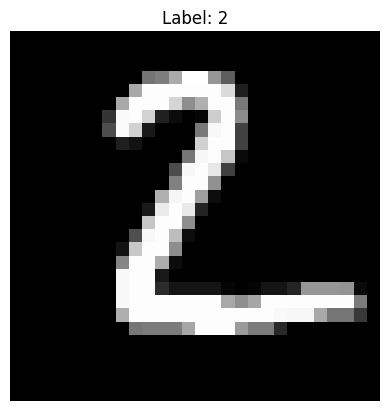

In [75]:
image = inputs
label = y_test[1]
# Plot the image
plt.imshow(image, cmap='gray')
plt.title('Label: {}'.format(label))
plt.axis('off')  # Turn off axis
plt.show()

In [105]:
x = torch.rand(3,4)

In [106]:
y = torch.rand(4,5)

In [108]:
(x@y).shape

RuntimeError: The size of tensor a (3) must match the size of tensor b (5) at non-singleton dimension 0

In [121]:
import tensorflow as tf
x = tf.ones([3,4])
y = tf.ones([4,5])

out = tf.expand_dims(x, axis=-1) * tf.expand_dims(y, axis=0)

In [124]:
out = 1 - tf.math.reduce_prod(1-out, axis=-2)

In [125]:
out.shape

TensorShape([3, 5])

In [99]:
torch.prod(1-(x * y),dim=-1)

RuntimeError: The size of tensor a (4) must match the size of tensor b (5) at non-singleton dimension 1

In [177]:
class ORLinear():
    def __init__(self, 
                 in_features,
                 out_features,
                 seq_len,
                 is_bias=False) -> None:
        super().__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.seq_len = seq_len
        self.is_bias = is_bias
        self.weight = None
        self.bias = None

    def load_weight(self, data):
        assert data['weight'].shape == torch.Size([self.in_features, self.out_features])

        self.weight = F2S(seq_len=self.seq_len)(data['weight'])

        if self.is_bias:
            assert data['bias'].shape == torch.Size([self.out_features])
            self.bias = F2S(seq_len=self.seq_len)(data['bias'])
            if len(self.bias.shape) <=2 : 
                self.bias = self.bias.unsqueeze(dim=0)
            self.weight = torch.cat([self.weight, self.bias], dim=0)

    def forward(self, inputs):
        out = torch.zeros(inputs.shape[:-2] + (self.out_features,self.seq_len),dtype=torch.bool)

        if self.is_bias:
            bias_input = torch.ones(1,self.seq_len, dtype=torch.bool).expand(inputs.shape[:-2]+(1,-1,))
            inputs = torch.concat([inputs, bias_input],dim=-2)


        for i in range(self.out_features):
            print(s2f(mul(inputs, self.weight[:,i])))
            out[...,i,:] = torch.any(mul(inputs, self.weight[:,i]),dim=-2)
        return out

In [178]:
l = ORLinear(100,10,10)

In [179]:
l.load_weight(data = {
    'weight':((torch.rand(100,10))-0.5)/1024
})

In [180]:
f2s = F2S(10)
s2f = S2F()

In [181]:
s2f(l.forward(inputs=f2s(torch.rand(3,100)-0.4)))

tensor([[-0.4000,  0.4000,  0.4000,  0.4000, -0.2000, -0.2000, -0.2000, -0.4000,
         -0.4000, -0.2000,  0.6000,  0.4000,  0.4000, -0.4000,  0.8000,  0.0000,
         -0.4000, -0.2000,  0.0000,  0.0000,  0.2000, -0.2000, -0.4000, -0.4000,
          0.2000, -0.4000,  0.4000, -0.4000, -0.6000, -0.4000, -0.2000, -0.8000,
          0.0000, -0.6000, -0.2000,  0.0000,  0.2000,  0.4000, -0.4000, -0.4000,
          0.0000,  0.0000,  0.0000,  0.2000, -0.2000,  0.0000,  0.0000,  0.2000,
         -0.4000,  0.4000,  0.2000,  0.2000, -0.2000, -0.2000,  0.0000, -0.2000,
         -0.2000,  0.4000, -0.2000, -0.4000, -0.2000, -0.4000, -0.2000, -0.4000,
         -0.4000,  0.4000,  0.0000, -0.2000,  0.0000,  0.0000,  0.0000, -0.2000,
         -0.2000, -0.2000,  0.0000,  0.8000, -0.4000,  0.0000,  0.2000, -0.6000,
         -0.2000, -0.4000, -0.6000, -0.6000,  0.6000,  0.2000,  0.0000,  0.4000,
         -0.2000, -0.2000,  0.4000,  0.0000, -0.2000,  0.0000,  0.2000,  0.4000,
          0.0000, -0.2000,  

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])